<a href="https://colab.research.google.com/github/ghostflare76/openllm/blob/main/reddit_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
!pip install --quiet --upgrade langchain langchain-google-genai cache-pandas

In [6]:
## Local 에서 수행시에는 API 키 정보 로드 및 환경 변수에서 값을 불러옴

from google.colab import userdata

GOOGLE_API_KEY=userdata.get("GOOGLE_API_KEY")
REDDIT_USERNAME=userdata.get("REDDIT_USERNAME")
REDDIT_PASSWORD=userdata.get("REDDIT_PASSWORD")
REDDIT_CLIENT_ID=userdata.get("REDDIT_CLIENT_ID")
REDDIT_CLIENT_SECRET=userdata.get("REDDIT_CLIENT_SECRET")


In [21]:
import requests
import pandas as pd
import os
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.schema import HumanMessage

In [10]:
class Post:
    def __init__(self, title, selftext, commentcnt, score, url):
        self.title = title
        self.selftext = selftext
        self.commentcnt = commentcnt
        self.score = score
        self.url = url

    def __str__(self):
        return f"Title: {self.title}\nSelftext: {self.selftext}\nCommentCnt: {self.commentcnt}\nScore: {self.score}\nUrl : {self.url}\n"

# Reddit 계정정보를 이용하여 Token 정보 획득

In [38]:
from cache_pandas import timed_lru_cache

@timed_lru_cache(seconds=60*60*24, maxsize=None)
def get_access_token() -> str:
    token_url = f"https://www.reddit.com/api/v1/access_token?grant_type=password&username={REDDIT_USERNAME}&password={REDDIT_PASSWORD}"
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3"
    }

    response = requests.post(token_url, auth=(REDDIT_CLIENT_ID, REDDIT_CLIENT_SECRET), headers=headers)

    if response.status_code != 200:
        print(f"Error acquiring access token: {response.status_code} - {response.text}")
        return None

    return response.json()["access_token"]




# 토큰을 이용하여 최신 리뷰 목록 조회

In [39]:
@timed_lru_cache(seconds=60*60*6, maxsize=None)
def get_new_posts():

    access_token = get_access_token()
    if not access_token:
        return None

    url = "https://oauth.reddit.com/r/throneandliberty/new"
    headers = {
        "Authorization": f"Bearer {access_token}",
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3"
    }

    response = requests.get(url, headers=headers)

    if response.status_code != 200:
        print(f"Error fetching new posts: {response.status_code} - {response.text}")
        return None

    return response.json()

In [40]:
import json
new_posts = get_new_posts()
if new_posts:
    print(json.dumps(new_posts["data"]["children"][0], indent=2))

{
  "kind": "t3",
  "data": {
    "approved_at_utc": null,
    "subreddit": "throneandliberty",
    "selftext": " Besides the amazing map and graphic design, which were done exceptionally well, the rest still appears to resemble a generic mobile game. The combat is adequate for tab targeting, but games like Aion or ArcheAge surpass the combat mechanics here. So, what is the selling point of TL? Does it have one?",
    "author_fullname": "t2_tfltw4xt6",
    "saved": false,
    "mod_reason_title": null,
    "gilded": 0,
    "clicked": false,
    "title": "Is TL \"lazy\" / \"outdated\"?",
    "link_flair_richtext": [],
    "subreddit_name_prefixed": "r/throneandliberty",
    "hidden": false,
    "pwls": 7,
    "link_flair_css_class": null,
    "downs": 0,
    "thumbnail_height": null,
    "top_awarded_type": null,
    "hide_score": false,
    "name": "t3_1cfvf58",
    "quarantine": false,
    "link_flair_text_color": "dark",
    "upvote_ratio": 0.22,
    "author_flair_background_color": n

In [41]:
posts = [Post(item['data']['title'], item['data']['selftext'], item['data']['num_comments'], item['data']['score'], item['data']['url']) for item in new_posts['data']['children']]

In [42]:
llm = ChatGoogleGenerativeAI(
    model="gemini-pro",
    google_api_key=GOOGLE_API_KEY
)

# 주어진 본문 내용 바탕으로 감정 분석후 3가지로 분류

In [51]:

def get_sentiment(text):
    prompt = HumanMessage(content=f"Analyze the sentiment of the following text: '{text}'. Return 'positive', 'negative', or 'neutral' based on the sentiment analysis.")
    response = llm([prompt])
    sentiment = response.content.strip().lower()

    if 'positive' in sentiment:
        return 'positive'
    elif 'negative' in sentiment:
        return 'negative'
    else:
        return 'neutral'


# 주어진 TEXT 기반으로 주요 keyword 5개를 추출

In [44]:

def get_keyword(text):
    prompt = HumanMessage(content=f"Extract just 5 keywords that matter from the given text: '{text}'. Return list them separated by commas.")
    response = llm([prompt])
    return response.content.strip().lower()


In [45]:
import time

def process_post(post):
    text = post.selftext
    sentiment = get_sentiment(text)
    if sentiment == 'negative':
        keyword = get_keyword(text)
    else:
        keyword = 'N/A'
    post_with_sentiment = {
        'title': post.title,
        'commentcnt': post.commentcnt,
        'score': post.score,
        'sentiment': sentiment,
        'keyword' : keyword,
        'url': post.url
    }
    return post_with_sentiment

In [52]:
posts_with_sentiments = []

# LLM 수행중에 SAFETY 관련 오류 발생시 예외 처리를 위해 Exception 처리 필요
for post in posts:
    try:
        post_with_sentiment = process_post(post)
    except Exception as e:
        print (f"An error occured : {e}")
        continue

    posts_with_sentiments.append(post_with_sentiment)

In [53]:
df = pd.DataFrame(posts_with_sentiments)

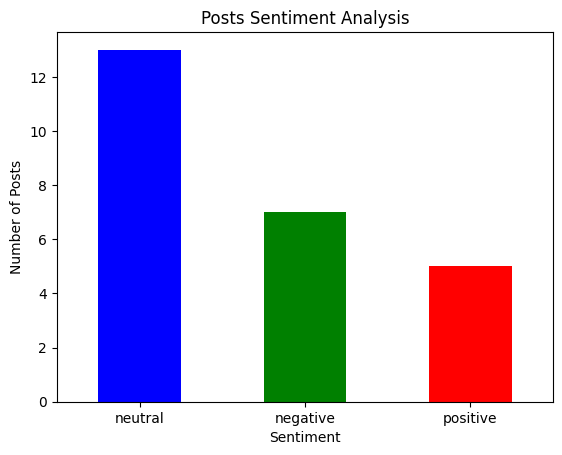

In [54]:

import matplotlib.pyplot as plt
sentiment_counts = df['sentiment'].value_counts()


sentiment_counts.plot(kind='bar', color=['blue', 'green', 'red'])

plt.title('Posts Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Number of Posts')
plt.xticks(rotation=0)
plt.show()

In [55]:
len(df)

25

In [56]:
from collections import Counter
import pandas as pd


all_keywords = ' '.join(df['keyword'].replace('N/A', ''))


# 2. 가장 많이 등장하는 키워드 찾기
keyword_counts = Counter(all_keywords.split())
top_keywords = dict(keyword_counts.most_common(20))



In [57]:
display(top_keywords)

{'game,': 2,
 'time': 2,
 'map,': 1,
 'graphic': 1,
 'design,': 1,
 'mobile': 1,
 'combat,': 1,
 'selling': 1,
 'point': 1,
 'log': 1,
 'in,': 1,
 'exitlag,': 1,
 'purple,': 1,
 'tal,': 1,
 'phone': 1,
 'number': 1,
 'nord': 1,
 'vpn,': 1,
 'exit': 1,
 'lag,': 1}

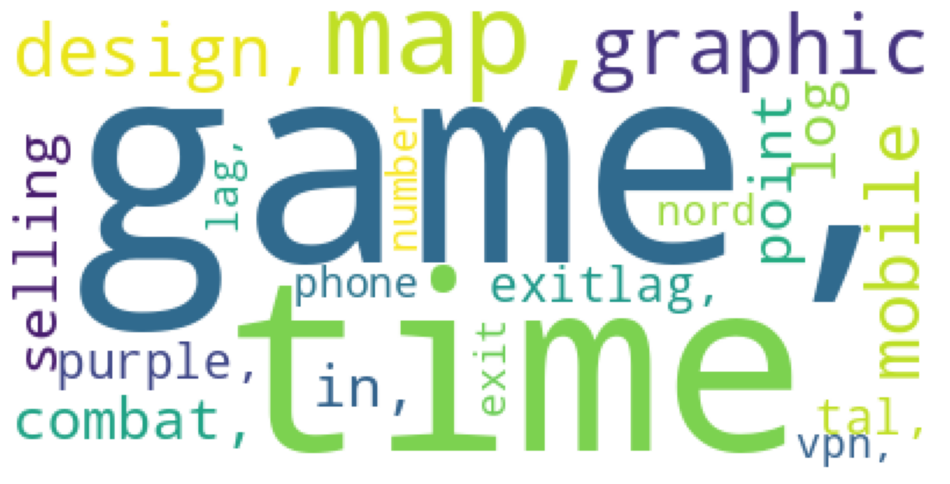

In [58]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
# 3. 워드 클라우드 생성
wordcloud = WordCloud(relative_scaling=0,background_color='white', stopwords=STOPWORDS).generate_from_frequencies(top_keywords)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()